## Skorch backprop
tpham328

Source: https://github.com/jlm429/pyperch/blob/master/notebooks

In [35]:
# import subprocess

# # Installation on Google Colab
# !git clone https://github.com/jlm429/pyperch
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
# sys.path.append('/content/pyperch')

# try:
#     import google.colab
#     subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
# except ImportError:
#     pass

In [36]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
from pyperch.neural.backprop_nn import BackpropModule 
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import learning_curve

In [37]:
data = pd.read_csv("winequality-white.csv")
print("Successfully Imported Data!")

data.head()
print(data.shape)

Successfully Imported Data!
(4898, 12)


In [38]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = 'quality')

# Y = data['quality']
# Y = [1 if x >= 7 else 0 for x in data['quality']]


original_Y = data['quality']
def class_quality(value):
    if value <= 5:
        return 0
    elif value == 6:
        return 1
    elif value >= 7:
        return 2

Y = original_Y.apply(class_quality)


# filtered_data = data[data['quality'].isin([4, 5, 6, 7, 8])]
# X = filtered_data.drop(columns='quality')
# Y = filtered_data['quality']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


Y.value_counts(0)

quality
1    2198
0    1640
2    1060
Name: count, dtype: int64

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=328)
print(Y_train.value_counts(0))
print(Y_test.value_counts(0))

quality
1    1748
0    1336
2     834
Name: count, dtype: int64
quality
1    450
0    304
2    226
Name: count, dtype: int64


In [40]:
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)

In [41]:
from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=11,
    module__output_dim=3,
    module__hidden_units=200,
    module__hidden_layers=2,
    max_epochs=1000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    lr=.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device = 'cuda'
)

In [42]:
net.fit(X_train, Y_train)


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BackpropModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=200, bias=True)
      (1-2): 2 x Linear(in_features=200, out_features=200, bias=True)
      (3): Linear(in_features=200, out_features=3, bias=True)
    )
  ),
)

## Plot learning curves

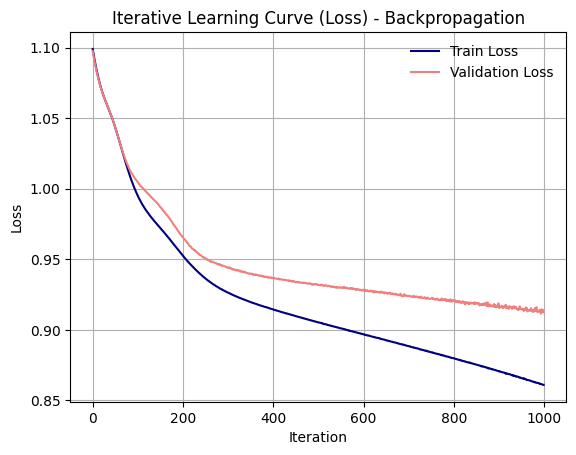

In [43]:
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss) - Backpropagation")
plt.grid(visible=True)
plt.legend(frameon=False)

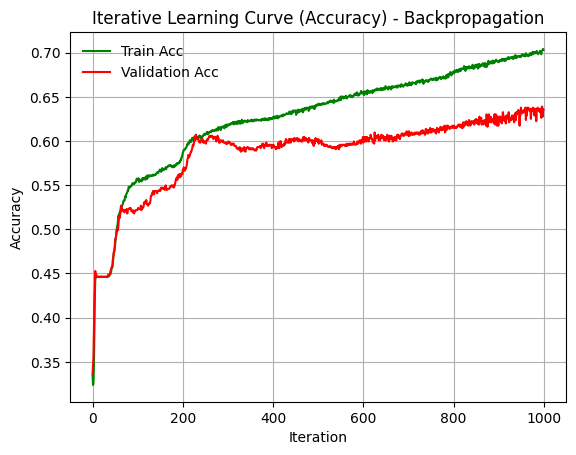

In [44]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='green')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='red')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy) - Backpropagation")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn learning curve with RO

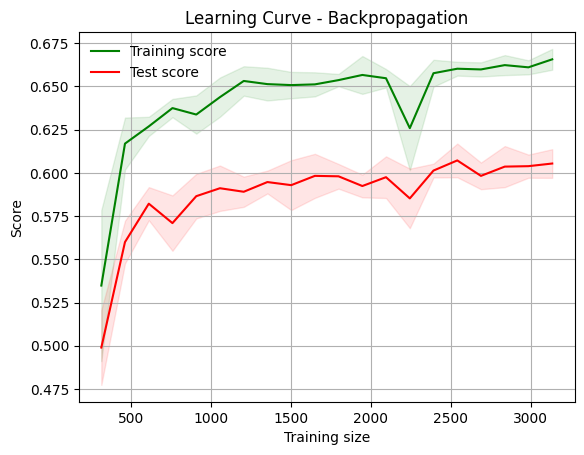

In [45]:


net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=11,
    module__output_dim=3,
    module__hidden_units=200,
    module__hidden_layers=2,
    max_epochs=100,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    lr=.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device = 'cuda',
)

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X_train, Y_train, train_sizes=np.linspace(0.1, 1.0, 20), cv=5
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='green')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='red')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='green')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='red')
plt.title("Learning Curve - Backpropagation")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn grid search 

In [46]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

default_params = {
    'module__input_dim': [11],
    'module__output_dim': [3],
}

# module specific parameters need to begin with 'module__'
params = {
    'lr': [0.05, 0.1, 0.2],
    'max_epochs': [20, 50, 100],
    'module__hidden_units': [100, 200],
    'module__hidden_layers': [2,3],
    **default_params,
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X_train, Y_train)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END lr=0.05, max_epochs=20, module__hidden_layers=2, module__hidden_units=100, module__input_dim=11, module__output_dim=3; total time=   1.7s
[CV] END lr=0.05, max_epochs=20, module__hidden_layers=2, module__hidden_units=100, module__input_dim=11, module__output_dim=3; total time=   1.7s
[CV] END lr=0.05, max_epochs=20, module__hidden_layers=2, module__hidden_units=100, module__input_dim=11, module__output_dim=3; total time=   1.7s
[CV] END lr=0.05, max_epochs=20, module__hidden_layers=2, module__hidden_units=200, module__input_dim=11, module__output_dim=3; total time=   1.8s
[CV] END lr=0.05, max_epochs=20, module__hidden_layers=2, module__hidden_units=200, module__input_dim=11, module__output_dim=3; total time=   2.0s
[CV] END lr=0.05, max_epochs=20, module__hidden_layers=2, module__hidden_units=200, module__input_dim=11, module__output_dim=3; total time=   1.6s
[CV] END lr=0.05, max_epochs=20, module__hidden_layers=3

In [49]:
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

C:\Users\trung\AppData\Local\Temp\ipykernel_270724\3217140360.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\trung\AppData\Local\Temp\ipykernel_270724\3217140360.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.long)


In [51]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
net.fit(X_train, Y_train)
# Predict on test data
Y_pred = net.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Compute F1 score for each class
f1 = f1_score(Y_test, Y_pred, average=None)
print(f'F1 Score (per class): {f1}')

# Compute and print the classification report
report = classification_report(Y_test, Y_pred, target_names=['low', 'medium', 'high'])
print(report)

Accuracy: 0.6194
F1 Score (per class): [0.64505119 0.63114754 0.55276382]
              precision    recall  f1-score   support

         low       0.67      0.62      0.65       304
      medium       0.59      0.68      0.63       450
        high       0.64      0.49      0.55       226

    accuracy                           0.62       980
   macro avg       0.63      0.60      0.61       980
weighted avg       0.62      0.62      0.62       980

